In [1]:
import sys, os 
import numpy as np 
import pandas as pd
from src import utils, plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import rcParams
default_font = 12
fs_title = 16
rcParams["font.family"] = "Arial"
rcParams["savefig.dpi"] = 300
rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.titlelocation"] = "left"
rcParams["axes.titleweight"] = "normal"
rcParams["font.size"] = default_font
trial_type_palette = ['tab:green', 'tab:red', 'tab:cyan', 'tab:orange', 'grey'] #rew #nrew #rew_test #nrew_test #GI

In [3]:
VG11 = []
VG11.append({'mname': 'VG11', 'datexp': '2024_10_31', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_14', 'blk':'2'})
VG14 = []
VG14.append({'mname': 'VG14', 'datexp': '2024_11_21', 'blk':'2'})
VG15 = []
VG15.append({'mname': 'VG15', 'datexp': '2024_10_31', 'blk':'2'})
all_sessions = VG11 + VG14 + VG15
all_sessions

[{'mname': 'VG11', 'datexp': '2024_10_31', 'blk': '2'},
 {'mname': 'VG11', 'datexp': '2024_11_14', 'blk': '2'},
 {'mname': 'VG14', 'datexp': '2024_11_21', 'blk': '2'},
 {'mname': 'VG15', 'datexp': '2024_10_31', 'blk': '2'}]

In [4]:
def compute_speed(frameselector):
    frameselector = frameselector.assign(speed = 0)
    for trial_no in frameselector["trial_no"].unique():
        trial_inf = frameselector.query(f"trial_no == {trial_no}")
        dt = trial_inf["time_within_trial"].diff().shift(-1)
        ddistance = trial_inf["distance"].diff().shift(-1)
        last_dd = ddistance.iloc[-2]
        last_dt = dt.iloc[-2]
        dt = dt.fillna(last_dt)
        ddistance = ddistance.fillna(last_dd)
        frameselector.loc[frameselector["trial_no"] == trial_no, "speed"] = ddistance / dt
    return frameselector

def get_interp_speed(m1):
    #compute speed
    m1.frameselector = compute_speed(m1.frameselector)
    ntrials = m1.frameselector["trial_no"].astype(int).max()
    speed_interp = np.empty((ntrials, 400))
    #interp speed to 400 positions
    for trial_no in m1.frameselector["trial_no"].unique():
        trial_no = int(trial_no)
        trial_speed = m1.frameselector.query(f"trial_no == {trial_no}")["speed"].values
        trial_distance = m1.frameselector.query(f"trial_no == {trial_no}")["distance"].values
        #if (trial_distance[0] > 0) & (trial_no > 1):
        #    previous_trial_speed = m1.frameselector.query(f"trial_no == {trial_no-1}")["speed"].values[-1]
        #    #append 0 to the beginning
        #    trial_distance = np.insert(trial_distance, 0, 0)
        #    trial_speed = np.insert(trial_speed, 0, previous_trial_speed)
        #elif (trial_distance[0] > 0) & (trial_no == 1):
        #    trial_distance = np.insert(trial_distance, 0, 0)
        #    trial_speed = np.insert(trial_speed, 0, trial_speed[0])
        #trial_distance = np.round(trial_distance, 0).astype(int)
        speed_interp[trial_no-1] = np.interp(np.arange(400), trial_distance, trial_speed)
    return speed_interp

def get_interp_speed_v2(m1):
    #compute speed
    df = utils.get_movement_df(m1)
    ntrials = m1.frameselector["trial_no"].astype(int).max()
    speed_interp = np.empty((ntrials, 400))
    #interp speed to 400 positions
    for trial_no in m1.frameselector["trial_no"].unique():
        trial_no = int(trial_no)
        trial_speed = df.query(f"trial == {trial_no}")["pitch"].values * 10
        trial_distance = df.query(f"trial == {trial_no}")["distance"].values
        speed_interp[trial_no-1] = np.interp(np.arange(400), trial_distance, trial_speed)
    return speed_interp

In [196]:
mean_speed_per_trial_type_andlick = np.empty((len(all_sessions), 4, 2, 400)) # animals, trial types, lick/no lick, 400 positions
from pathlib import Path
for iss, sess in enumerate(all_sessions):
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
    speed_interp = get_interp_speed_v2(m1)
    main_dir = Path(f"../data/{name}/{date}/{blk}")
    if not main_dir.exists():
        main_dir.mkdir(parents=True)
    np.save(main_dir / "speed_interp.npy", speed_interp)
    for it, (ttype, trials) in enumerate(m1.trial_dict.items()):
        t_licks, t_no_licks = utils.get_trials_with_licks(m1, lick_window=(150,250), trialtype=ttype)
        mean_licks = np.mean(speed_interp[t_licks], axis=0)
        mean_no_licks = np.mean(speed_interp[t_no_licks], axis=0)
        mean_speed_per_trial_type_andlick[iss, it, 0] =  mean_licks
        mean_speed_per_trial_type_andlick[iss, it, 1] =  mean_no_licks
np.save("../data/overall/mean_speed_per_trial_type_andlick.npy", mean_speed_per_trial_type_andlick)

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_21\2
Existing mouse object has the following attr

In [6]:
mean_speed_per_trial_type_andlick = np.load("../data/overall/mean_speed_per_trial_type_andlick.npy")

In [7]:
from scipy.stats import sem
cat_a = mean_speed_per_trial_type_andlick[:,[0,2],:].mean(1)
cat_b = mean_speed_per_trial_type_andlick[:,[1,3],:].mean(1)
rew_gran_mean = cat_a.mean(axis=0)
rew_gran_sem = sem(cat_a, axis=0)
nrew_gran_mean = cat_b.mean(axis=0)
nrew_gran_sem = sem(cat_b, axis=0)

In [9]:
nrew_gran_mean.shape

(2, 400)

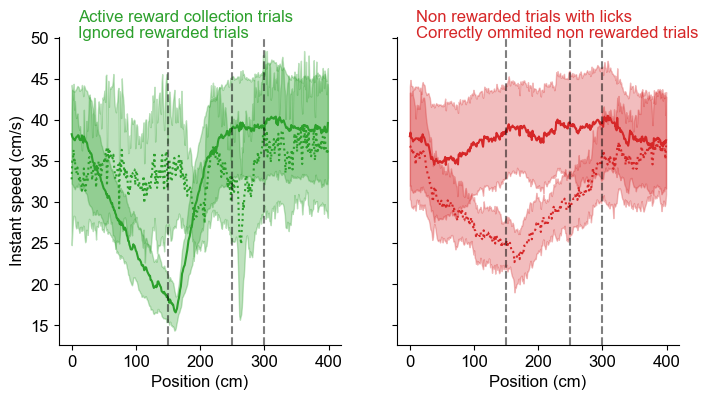

In [21]:

fig, ax = plt.subplots(1,2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].plot(rew_gran_mean[0], color='tab:green')
ax[0].fill_between(np.arange(400), rew_gran_mean[0]-rew_gran_sem[0], rew_gran_mean[0]+rew_gran_sem[0], alpha=0.3, color='tab:green')
ax[0].plot(rew_gran_mean[1], color='tab:green', linestyle=':')
ax[0].fill_between(np.arange(400), rew_gran_mean[1]-rew_gran_sem[1], rew_gran_mean[1]+rew_gran_sem[1], alpha=0.3, color='tab:green')
ax[1].plot(nrew_gran_mean[0], color='tab:red', linestyle=':')
ax[1].fill_between(np.arange(400), nrew_gran_mean[0]-nrew_gran_sem[0], nrew_gran_mean[0]+nrew_gran_sem[0], alpha=0.3, color='tab:red')
ax[1].plot(nrew_gran_mean[1], color='tab:red')
ax[1].fill_between(np.arange(400), nrew_gran_mean[1]-nrew_gran_sem[1], nrew_gran_mean[1]+nrew_gran_sem[1], alpha=0.3, color='tab:red')
ax[0].set_ylabel("Instant speed (cm/s)")
ax[0].text(10,52, "Active reward collection trials", color='tab:green')
ax[1].text(10,52, "Non rewarded trials with licks", color='tab:red')
ax[0].text(10,50, "Ignored rewarded trials", color='tab:green')
ax[1].text(10,50, "Correctly ommited non rewarded trials", color='tab:red')
for i in range(2):
    ax[i].set_xlabel("Position (cm)")
    ax[i].axvline(150, color='k', linestyle='--', alpha=0.5)
    ax[i].axvline(250, color='k', linestyle='--', alpha=0.5)
    ax[i].axvline(300, color='k', linestyle='--', alpha=0.5)

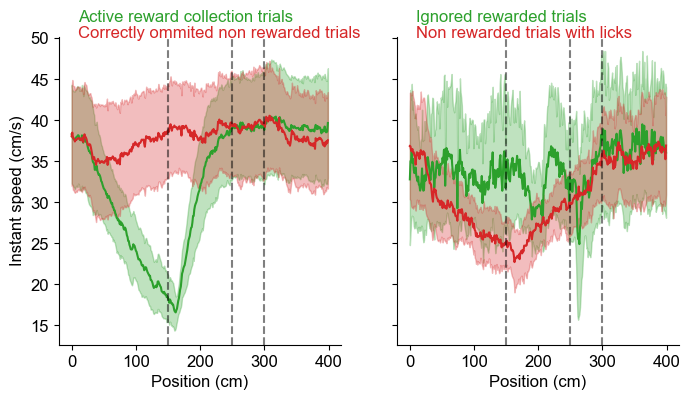

In [12]:
from scipy.stats import sem
cat_a = mean_speed_per_trial_type_andlick[:,[0,2],:].mean(1)
cat_b = mean_speed_per_trial_type_andlick[:,[1,3],:].mean(1)
rew_gran_mean = cat_a.mean(axis=0)
rew_gran_sem = sem(cat_a, axis=0)
nrew_gran_mean = cat_b.mean(axis=0)
nrew_gran_sem = sem(cat_b, axis=0)
fig, ax = plt.subplots(1,2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].plot(rew_gran_mean[0], color='tab:green')
ax[0].fill_between(np.arange(400), rew_gran_mean[0]-rew_gran_sem[0], rew_gran_mean[0]+rew_gran_sem[0], alpha=0.3, color='tab:green')
ax[0].plot(nrew_gran_mean[1], color='tab:red')
ax[0].fill_between(np.arange(400), nrew_gran_mean[1]-nrew_gran_sem[1], nrew_gran_mean[1]+nrew_gran_sem[1], alpha=0.3, color='tab:red')
ax[1].plot(rew_gran_mean[1], color='tab:green')
ax[1].fill_between(np.arange(400), rew_gran_mean[1]-rew_gran_sem[1], rew_gran_mean[1]+rew_gran_sem[1], alpha=0.3, color='tab:green')
ax[1].plot(nrew_gran_mean[0], color='tab:red')
ax[1].fill_between(np.arange(400), nrew_gran_mean[0]-nrew_gran_sem[0], nrew_gran_mean[0]+nrew_gran_sem[0], alpha=0.3, color='tab:red')
ax[0].set_ylabel("Instant speed (cm/s)")
ax[0].text(10,52, "Active reward collection trials", color='tab:green')
ax[0].text(10,50, "Correctly ommited non rewarded trials" , color='tab:red')
ax[1].text(10,52, "Ignored rewarded trials", color='tab:green')
ax[1].text(10,50, "Non rewarded trials with licks", color='tab:red')
for i in range(2):
    ax[i].set_xlabel("Position (cm)")
    ax[i].axvline(150, color='k', linestyle='--', alpha=0.5)
    ax[i].axvline(250, color='k', linestyle='--', alpha=0.5)
    ax[i].axvline(300, color='k', linestyle='--', alpha=0.5)

Ttest_relResult(statistic=-0.5738049372938795, pvalue=0.6062949095088941)
Ttest_relResult(statistic=-1.9735356828102115, pvalue=0.14295378129012296)


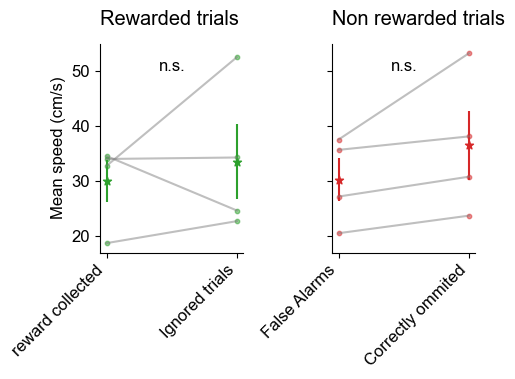

In [22]:
overall_speed_A = cat_a[:,:,0:125].mean(-1)
overall_speed_B = cat_b[:,:,0:125].mean(-1)
overall_speed_A_sem = sem(overall_speed_A, axis=0)
overall_speed_B_sem = sem(overall_speed_B, axis=0)

fig, ax = plt.subplots(1,2, figsize=(5, 4), sharey=True)
for animal in range(4):
    ax[0].scatter(0,overall_speed_A[animal,0], color='tab:green', label="Active reward collection", alpha=0.5, s=10)
    ax[0].scatter(1,overall_speed_A[animal,1],  color='tab:green', label="Ignored rewarded trials", alpha=0.5, s=10)
    ax[1].scatter(0,overall_speed_B[animal,0], color='tab:red', label="Non rewarded trials with licks", alpha=0.5, s=10)
    ax[1].scatter(1,overall_speed_B[animal,1], color='tab:red', label="Correctly ommited non rewarded trials",alpha=0.5, s=10)
ax[0].errorbar(0, overall_speed_A.mean(0)[0], yerr=overall_speed_A_sem[0], color='tab:green')
ax[0].scatter(0, overall_speed_A.mean(0)[0], marker='*', color='tab:green')
ax[0].errorbar(1, overall_speed_A.mean(0)[1], yerr=overall_speed_A_sem[1], color='tab:green')
ax[0].scatter(1, overall_speed_A.mean(0)[1], marker='*', color='tab:green')
ax[1].errorbar(0, overall_speed_B.mean(0)[0], yerr=overall_speed_B_sem[0], color='tab:red')
ax[1].scatter(0, overall_speed_B.mean(0)[0], marker='*', color='tab:red')
ax[1].errorbar(1, overall_speed_B.mean(0)[1], yerr=overall_speed_B_sem[1], color='tab:red')
ax[1].scatter(1, overall_speed_B.mean(0)[1], marker='*', color='tab:red')
ax[0].set_ylabel("Mean speed (cm/s)")
ax[0].set_title("Rewarded trials", y=1.05)
ax[1].set_title("Non rewarded trials", y=1.05)
ax[0].set_xticks([0,1], ["reward collected", "Ignored trials"], rotation=45, ha='right');
ax[1].set_xticks([0,1], ["False Alarms", "Correctly ommited"], rotation=45, ha='right');
# connect dots 
for animal in range(4):
    ax[0].plot([0,1], [overall_speed_A[animal,0], overall_speed_A[animal,1]], color='grey', alpha=0.5)
    ax[1].plot([0,1], [overall_speed_B[animal,0], overall_speed_B[animal,1]], color='grey', alpha=0.5)
ax[0].text(0.4, 50, "n.s.")
ax[1].text(0.4, 50, "n.s.")
plt.tight_layout()
# compute the paired ttest between the two conditions
from scipy.stats import ttest_rel
print(ttest_rel(overall_speed_A[:,0], overall_speed_A[:,1]))
print(ttest_rel(overall_speed_B[:,0], overall_speed_B[:,1]))



Ttest_relResult(statistic=-1.273512494064042, pvalue=0.29255227911268594)
Ttest_relResult(statistic=-0.8243318265273566, pvalue=0.47017915205326694)


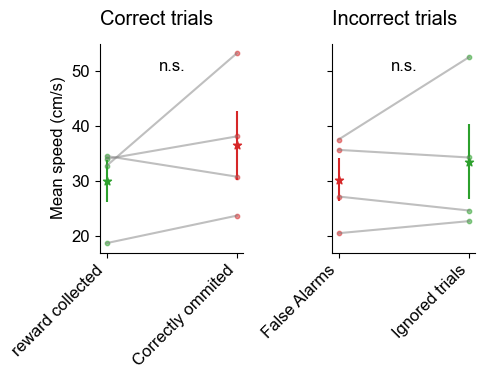

In [17]:
overall_speed_A = cat_a[:,:,0:125].mean(-1)
overall_speed_B = cat_b[:,:,0:125].mean(-1)
overall_speed_A_sem = sem(overall_speed_A, axis=0)
overall_speed_B_sem = sem(overall_speed_B, axis=0)

fig, ax = plt.subplots(1,2, figsize=(5, 4), sharey=True)
for animal in range(4):
    ax[0].scatter(0,overall_speed_A[animal,0], color='tab:green',  alpha=0.5, s=10)
    ax[0].scatter(1,overall_speed_B[animal,1],  color='tab:red', alpha=0.5, s=10)
    ax[1].scatter(0,overall_speed_B[animal,0], color='tab:red', alpha=0.5, s=10)
    ax[1].scatter(1,overall_speed_A[animal,1], color='tab:green', alpha=0.5, s=10)
ax[0].errorbar(0, overall_speed_A.mean(0)[0], yerr=overall_speed_A_sem[0], color='tab:green')
ax[0].scatter(0, overall_speed_A.mean(0)[0], marker='*', color='tab:green')
ax[0].errorbar(1, overall_speed_B.mean(0)[1], yerr=overall_speed_B_sem[1], color='tab:red')
ax[0].scatter(1, overall_speed_B.mean(0)[1], marker='*', color='tab:red')
ax[1].errorbar(0, overall_speed_B.mean(0)[0], yerr=overall_speed_B_sem[0], color='tab:red')
ax[1].scatter(0, overall_speed_B.mean(0)[0], marker='*', color='tab:red')
ax[1].errorbar(1, overall_speed_A.mean(0)[1], yerr=overall_speed_A_sem[1], color='tab:green')
ax[1].scatter(1, overall_speed_A.mean(0)[1], marker='*', color='tab:green')
ax[0].set_ylabel("Mean speed (cm/s)")
ax[0].set_title("Correct trials", y=1.05)
ax[1].set_title("Incorrect trials", y=1.05)
ax[0].set_xticks([0,1], ["reward collected", "Correctly ommited"], rotation=45, ha='right');
ax[1].set_xticks([0,1], ["False Alarms", "Ignored trials"], rotation=45, ha='right');
# connect dots 
for animal in range(4):
    ax[0].plot([0,1], [overall_speed_A[animal,0], overall_speed_B[animal,1]], color='grey', alpha=0.5)
    ax[1].plot([0,1], [overall_speed_B[animal,0], overall_speed_A[animal,1]], color='grey', alpha=0.5)
ax[0].text(0.4, 50, "n.s.")
ax[1].text(0.4, 50, "n.s.")
plt.tight_layout()
# compute the paired ttest between the two conditions
from scipy.stats import ttest_rel
print(ttest_rel(overall_speed_A[:,0], overall_speed_B[:,1]))
print(ttest_rel(overall_speed_B[:,0], overall_speed_A[:,1]))

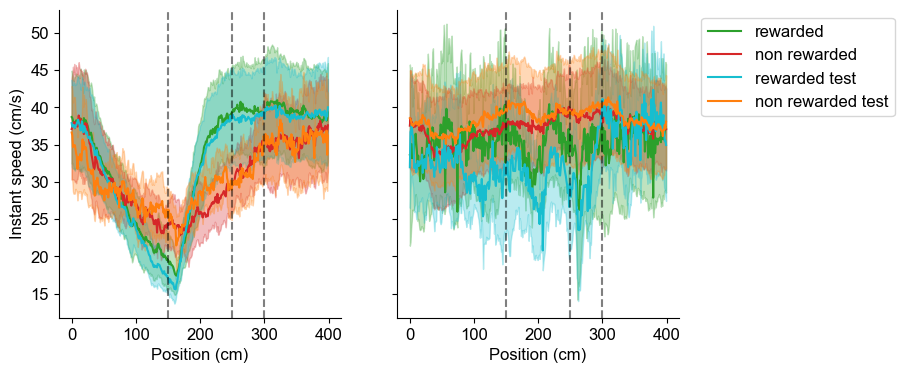

In [199]:
from scipy.stats import sem
grand_mean = np.mean(mean_speed_per_trial_type_andlick, axis=0)
gsem = sem(mean_speed_per_trial_type_andlick, axis=0)
fig, ax = plt.subplots(1,2, figsize=(8, 4), sharex=True, sharey=True)
for it, ttype in enumerate(m1.trial_dict.keys()):
    ax[0].plot(grand_mean[it, 0], label=ttype, color=trial_type_palette[it])
    ax[0].fill_between(np.arange(400), grand_mean[it, 0]-gsem[it, 0], grand_mean[it, 0]+gsem[it, 0], alpha=0.3, color=trial_type_palette[it])
    ax[1].plot(grand_mean[it, 1], label=ttype, color=trial_type_palette[it])
    ax[1].fill_between(np.arange(400), grand_mean[it, 1]-gsem[it, 1], grand_mean[it, 1]+gsem[it, 1], alpha=0.3, color=trial_type_palette[it])
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_ylabel("Instant speed (cm/s)")
for i in range(2):
    ax[i].set_xlabel("Position (cm)")
    ax[i].axvline(150, color='k', linestyle='--', alpha=0.5)
    ax[i].axvline(250, color='k', linestyle='--', alpha=0.5)
    ax[i].axvline(300, color='k', linestyle='--', alpha=0.5)

In [ ]:
from scipy.stats import pearsonr
areas = ["V1", "medial", "lateral", "anterior"]
cod_dirs = np.empty((len(all_sessions), 4, 2, 4), dtype=object)
speeds = np.empty((len(all_sessions), 4), dtype=object)
cod_speed_corr = np.empty((len(all_sessions), 4, 2))
cod_speed_p = np.empty((len(all_sessions), 4, 2))
for iss, sess in enumerate(all_sessions):
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
    speed = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/speed_interp.npy")
    speed = speed[:,:125].mean(axis=1)
    if redcell == 0: 
        selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
    else:
        selected_type = m1.isred[:,0].astype(bool)
    for indexa, area in enumerate(areas):
        for redcell in range(2):
            ia = utils.get_region_idx(m1.iarea, area)
            pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
            prefer_r = (m1.train_dp>=pstv_tsh)
            prefer_nr = (m1.train_dp<=ngtv_tsh)
            area_prefer_r = prefer_r * ia * selected_type
            area_prefer_nr = prefer_nr * ia * selected_type
            dir_for_type = m1.interp_spks 
            dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
            avg_dir = dir_for_type.mean(0)
            avg_dir = avg_dir[:,:125].mean(axis=1)
            cod_speed_corr[iss,indexa,redcell] = pearsonr(speed, avg_dir)[0]
            cod_speed_p[iss,indexa,redcell] = pearsonr(speed, avg_dir)[1]
            for it, (ttype, trials) in enumerate(m1.trial_dict.items()):
                speeds[iss, it] = speed[trials]
                cod_dirs[iss,indexa,redcell, it] = avg_dir[trials]            

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_21\2
Existing mouse object has the following attr

In [128]:
def significance(pval):
    if pval >= 0.05:
        text =  " "
    elif pval < 0.05:
        text = "*"
    elif pval < 0.01 & pval >= 0.001:
        text = "**"
    else:
        text = "***"
    return text

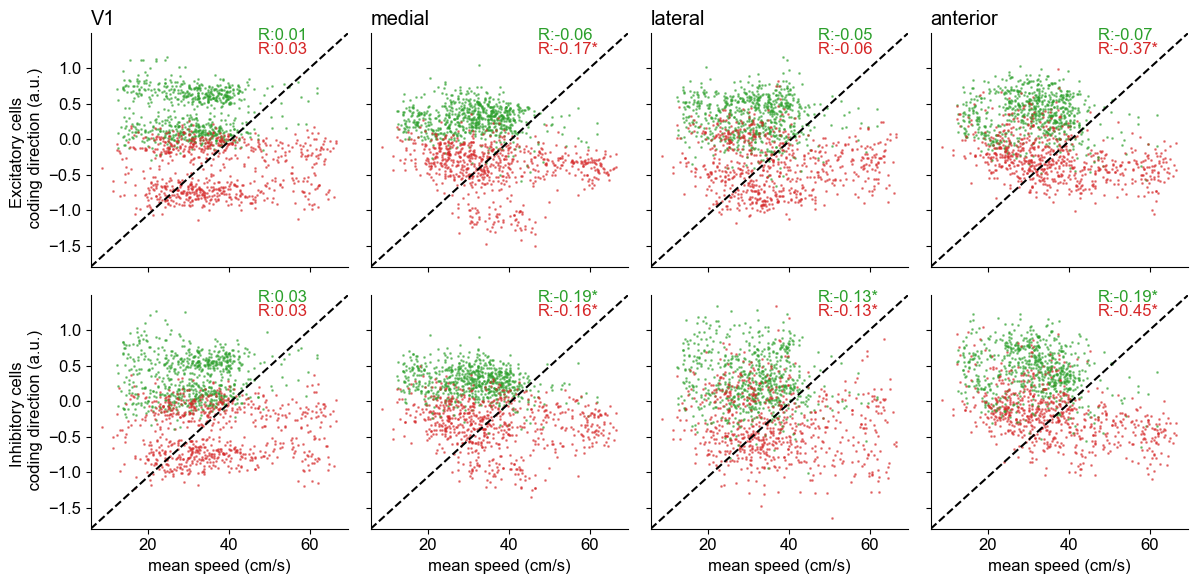

In [129]:
fig, ax = plt.subplots(2,4, figsize=(12, 6), sharey=True, sharex=True)
for icell in range(2):
    ax[icell,0].set_ylabel(f"{'Excitatory' if icell == 0 else 'Inhibitory'} cells \n coding direction (a.u.)")
    for ia in range(4):
        ax[icell,ia].plot([0, 1], [0, 1], transform=ax[icell,ia].transAxes, color='k', linestyle='--')
        for it in range(4):
            if it in [0,2]:
                ax[icell,ia].scatter(np.concatenate(speeds[:,it]), np.concatenate(cod_dirs[:,ia,icell,it]), color='tab:green', alpha=0.5, s=1)
            else:
                ax[icell,ia].scatter(np.concatenate(speeds[:,it]), np.concatenate(cod_dirs[:,ia,icell,it]), color='tab:red', alpha=0.5, s=1)
            ax[0,ia].set_title(areas[ia])
            ax[1,ia].set_xlabel("mean speed (cm/s)")
r_speeds = np.concatenate([elem.flatten() for row in speeds[:,[0,2]] for elem in row])
nr_speeds = np.concatenate([elem.flatten() for row in speeds[:,[1,3]] for elem in row])
for ia in range(4):
    for icell in range(2):
        r_cd = np.concatenate([elem.flatten() for row in cod_dirs[:,ia,icell,[0,2]] for elem in row]) 
        nr_cd = np.concatenate([elem.flatten() for row in cod_dirs[:,ia,icell,[1,3]] for elem in row]) 
        r_cor, r_p = pearsonr(r_speeds, r_cd)
        nr_cor, nr_p = pearsonr(nr_speeds, nr_cd)
        ax[icell,ia].text(.65, .97, transform=ax[icell,ia].transAxes, s=f"R:{r_cor:.2f}{significance(r_p)}", color='tab:green')
        ax[icell,ia].text(.65, .91, transform=ax[icell,ia].transAxes, s=f"R:{nr_cor:.2f}{significance(nr_p)}", color='tab:red')
plt.tight_layout()

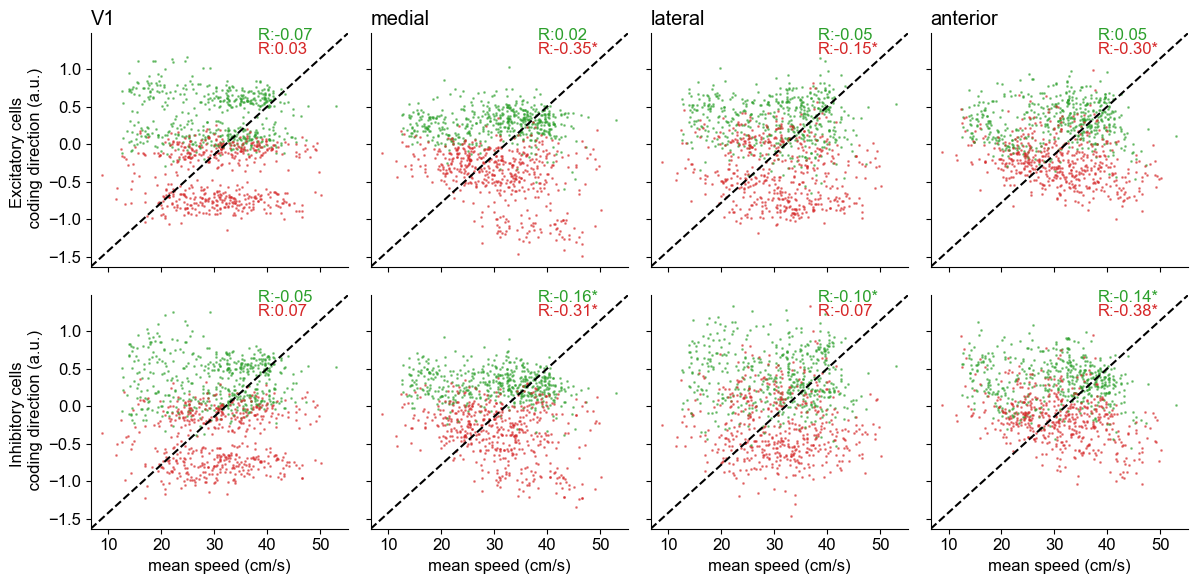

In [125]:
fig, ax = plt.subplots(2,4, figsize=(12, 6), sharey=True, sharex=True)
mice = [0, 2, 3]
for icell in range(2):
    ax[icell,0].set_ylabel(f"{'Excitatory' if icell == 0 else 'Inhibitory'} cells \n coding direction (a.u.)")
    for ia in range(4):
        ax[icell,ia].plot([0, 1], [0, 1], transform=ax[icell,ia].transAxes, color='k', linestyle='--')
        for it in range(4):
            if it in [0,2]:
                ax[icell,ia].scatter(np.concatenate(speeds[mice,it]), np.concatenate(cod_dirs[mice,ia,icell,it]), color='tab:green', alpha=0.5, s=1)
            else:
                ax[icell,ia].scatter(np.concatenate(speeds[mice,it]), np.concatenate(cod_dirs[mice,ia,icell,it]), color='tab:red', alpha=0.5, s=1)
            ax[0,ia].set_title(areas[ia])
            ax[1,ia].set_xlabel("mean speed (cm/s)")
or_s = speeds[:,[0,2]]
or_s = or_s[[0,2,3]] 
onr_s = speeds[:,[1,3]]
onr_s = onr_s[[0,2,3]]           
r_speeds = np.concatenate([elem.flatten() for row in or_s for elem in row])
nr_speeds = np.concatenate([elem.flatten() for row in onr_s for elem in row])
for ia in range(4):
    for icell in range(2):
        cd = cod_dirs[:,ia,icell,[0,2]]
        cd_r = cd[[0,2,3]]
        cd = cod_dirs[:,ia,icell,[1,3]]
        cd_nr = cd[[0,2,3]]
        r_cd = np.concatenate([elem.flatten() for row in cd_r for elem in row]) 
        nr_cd = np.concatenate([elem.flatten() for row in cd_nr for elem in row]) 
        r_cor, r_p = pearsonr(r_speeds, r_cd)
        nr_cor, nr_p = pearsonr(nr_speeds, nr_cd)
        ax[icell,ia].text(.65, .97, transform=ax[icell,ia].transAxes, s=f"R:{r_cor:.2f}{significance(r_p)}", color='tab:green')
        ax[icell,ia].text(.65, .91, transform=ax[icell,ia].transAxes, s=f"R:{nr_cor:.2f}{significance(nr_p)}", color='tab:red')
plt.tight_layout()

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_21\2
Existing mouse object has the following attr

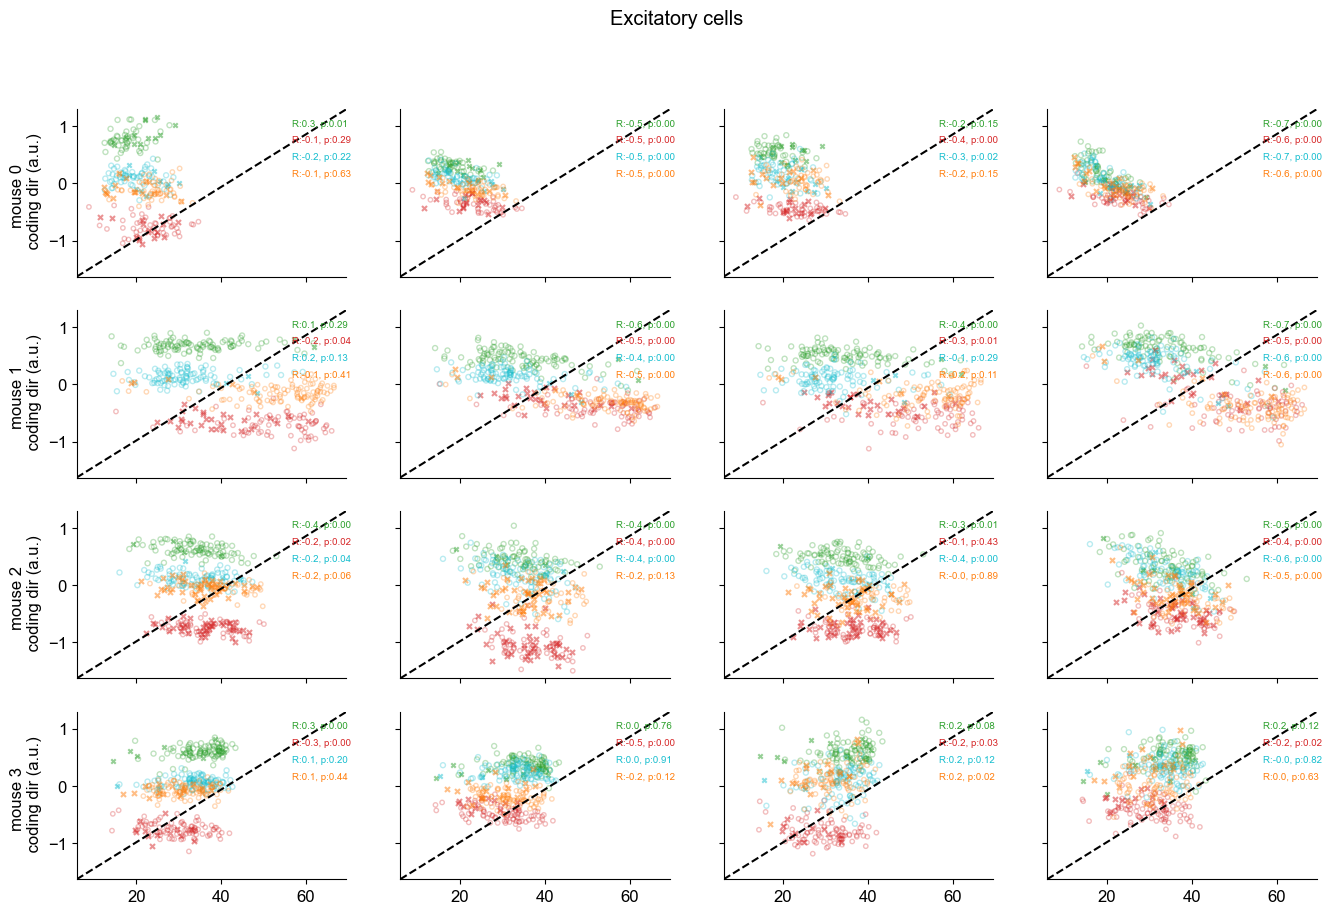

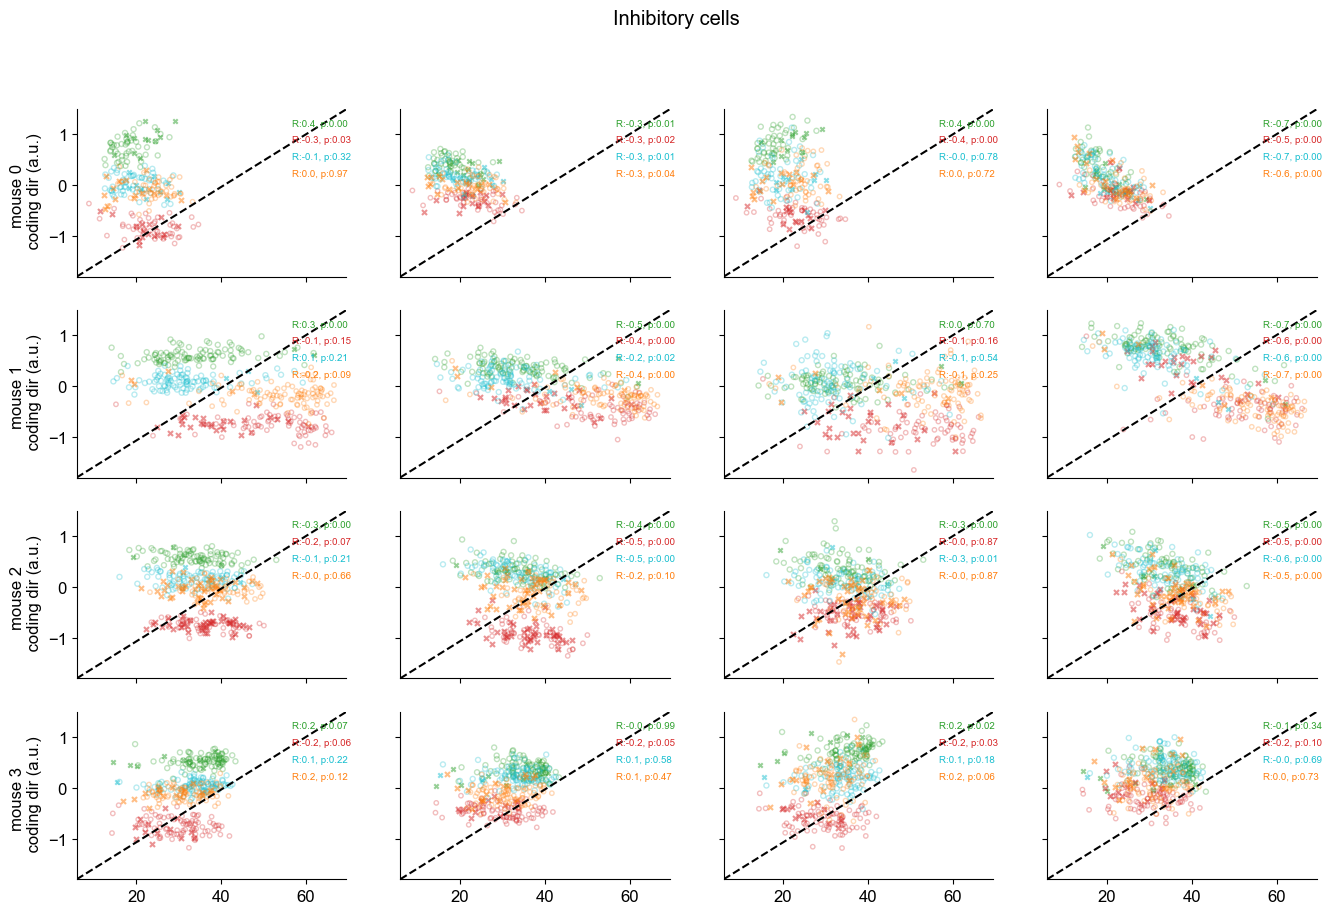

In [34]:
from scipy.stats import pearsonr
areas = ["V1", "medial", "lateral", "anterior"]

for redcell in range(2):
    fig, ax = plt.subplots(4,4, figsize=(16, 10), sharey=True, sharex=True)
    if redcell == 0: 
        title = "Excitatory cells"
    else:
        title = "Inhibitory cells"
    fig.suptitle(f"{title}")
    for iss, sess in enumerate(all_sessions):
        name = sess['mname']
        date = sess['datexp']
        blk = sess['blk']
        ax[iss, 0].set_ylabel(f"mouse {iss} \n coding dir (a.u.)")
        m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
        speed = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/speed_interp.npy")
        speed = speed[:,:125].mean(axis=1)
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
        else:
            selected_type = m1.isred[:,0].astype(bool)
        for indexa, area in enumerate(areas):
            ia = utils.get_region_idx(m1.iarea, area)
            pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
            prefer_r = (m1.train_dp>=pstv_tsh)
            prefer_nr = (m1.train_dp<=ngtv_tsh)
            area_prefer_r = prefer_r * ia * selected_type
            area_prefer_nr = prefer_nr * ia * selected_type
            dir_for_type = m1.interp_spks 
            dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
            avg_dir = dir_for_type.mean(0)
            avg_dir = avg_dir[:,:125].mean(axis=1)
            ax[iss, indexa].plot([0, 1], [0, 1], transform=ax[iss, indexa].transAxes, color='k', linestyle='--')
            for it, (ttype, trials) in enumerate(m1.trial_dict.items()):
                t_licks, t_no_licks = utils.get_trials_with_licks(m1, lick_window=(150,250), trialtype=ttype)
                if ttype in ["rewarded", "rewarded test"]:
                    ax[iss, indexa].scatter(speed[t_licks], avg_dir[t_licks], color=trial_type_palette[it], label=ttype, alpha=0.3, s=13, marker='o', facecolors='none')
                    ax[iss, indexa].scatter(speed[t_no_licks], avg_dir[t_no_licks], color=trial_type_palette[it], label=ttype, alpha=0.5, s=10, marker='x')
                    ax[iss, indexa].text(.8, .9-(it*.1), transform=ax[iss,indexa].transAxes, 
                                        s=f"R:{pearsonr(speed[trials], avg_dir[trials])[0]:.1f}, p:{pearsonr(speed[trials], avg_dir[trials])[1]:.2f}",
                                        color=trial_type_palette[it], fontsize=7)
                else:
                    ax[iss, indexa].scatter(speed[t_licks], avg_dir[t_licks], color=trial_type_palette[it], label=ttype, alpha=0.5, s=13, marker='x')
                    ax[iss, indexa].scatter(speed[t_no_licks], avg_dir[t_no_licks], color=trial_type_palette[it], label=ttype, alpha=0.3, s=10, marker='o', facecolors='none')
                    ax[iss, indexa].text(.8, .9-(it*.1), transform=ax[iss,indexa].transAxes, 
                                        s=f"R:{pearsonr(speed[trials], avg_dir[trials])[0]:.1f}, p:{pearsonr(speed[trials], avg_dir[trials])[1]:.2f}",
                                        color=trial_type_palette[it], fontsize=7)

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_21\2
Existing mouse object has the following attr

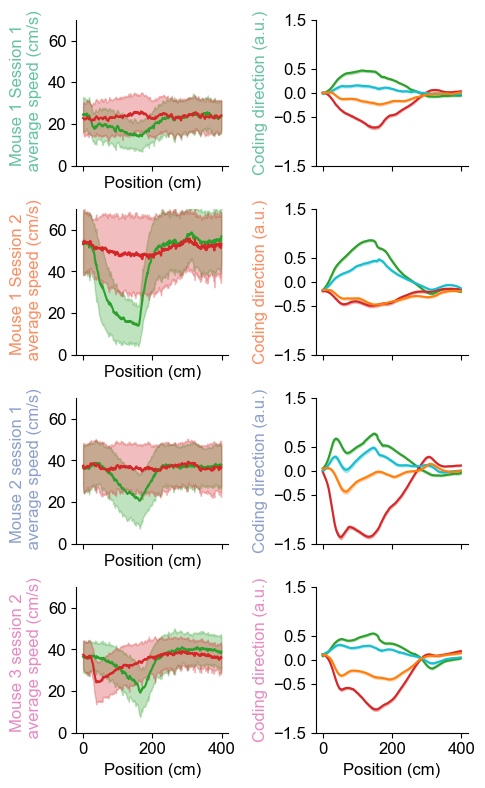

In [156]:
from scipy.stats import pearsonr
mouse_labels = ["Mouse 1 Session 1 \n average speed (cm/s)", "Mouse 1 Session 2 \n average speed (cm/s)", "Mouse 2 session 1 \n average speed (cm/s)", "Mouse 3 session 2 \n average speed (cm/s)"]
mouse_colors = sns.color_palette("Set2", 4)
fig, ax = plt.subplots(4,2, figsize=(5, 8), sharex=True)
for iss, sess in enumerate(all_sessions):
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
    speed = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/speed_interp.npy")
    #speed = speed[:,:125].mean(axis=1)
    A_cat = np.concatenate((m1.trial_dict["rewarded"], m1.trial_dict["rewarded test"]))
    B_cat = np.concatenate((m1.trial_dict["non rewarded"], m1.trial_dict["non rewarded test"]))
    for it,  trials in enumerate([A_cat, B_cat]):
        ax[iss, 0].plot(np.arange(400), speed[trials].mean(0), color=trial_type_palette[it], label=ttype)
        ax[iss, 0].fill_between(np.arange(400), speed[trials].mean(0)-speed[trials].std(0), speed[trials].mean(0)+speed[trials].std(0), alpha=0.3, color=trial_type_palette[it])
        ax[iss, 0].set_ylabel(mouse_labels[iss], color=mouse_colors[iss])
        ax[iss, 0].set_xlabel("Position (cm)")
        ax[iss, 0].set_ylim(0, 70)
        ax[iss,1].set_yticks(np.arange(0, 70, 20))
    selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
    ia = utils.get_region_idx(m1.iarea, "medial")
    pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia * selected_type
    area_prefer_nr = prefer_nr * ia * selected_type
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for it, (ttype, trials) in enumerate(m1.trial_dict.items()):
        ax[iss,1].plot(np.arange(400), avg_dir[trials].mean(0), color=trial_type_palette[it], label=ttype)
        ax[iss,1].fill_between(np.arange(400), avg_dir[trials].mean(0)-sem(avg_dir[trials], axis=0), avg_dir[trials].mean(0)+sem(avg_dir[trials], axis=0), alpha=0.3, color=trial_type_palette[it])
        ax[iss,1].set_ylabel("Coding direction (a.u.)", color=mouse_colors[iss])
        ax[iss,1].set_ylim(-1.5, 1.5)
        ax[iss,1].set_yticks([-1.5, -.5, 0, .5, 1.5])
ax[-1,0].set_xlabel("Position (cm)")
ax[-1,1].set_xlabel("Position (cm)")
plt.tight_layout()
plt.savefig("../results/speed_and_dir_medial_area.svg", bbox_inches='tight')

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_21\2
Existing mouse object has the following attr

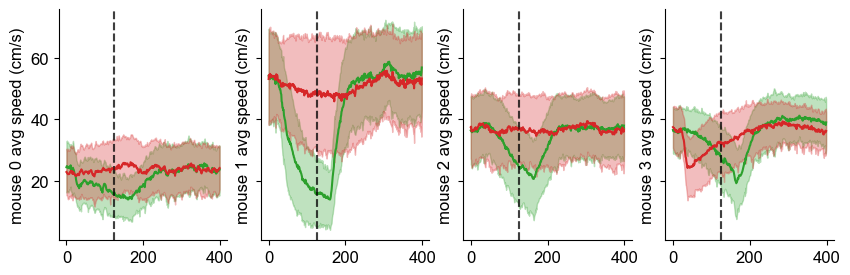

In [41]:
from scipy.stats import pearsonr
areas = ["V1", "medial", "lateral", "anterior"]
fig, ax = plt.subplots(1,4, figsize=(10, 3), sharey=True, sharex=True)
for iss, sess in enumerate(all_sessions):
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    ax[iss].set_ylabel(f"mouse {iss} avg speed (cm/s)")
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
    speed = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/speed_interp.npy")
    A_trials = np.concatenate([m1.trial_dict['rewarded'], m1.trial_dict['rewarded test']])
    B_trials = np.concatenate([m1.trial_dict['non rewarded'], m1.trial_dict['non rewarded test']])
    for it, trials in enumerate([A_trials, B_trials]):
        ax[iss].plot(np.arange(400), speed[trials].mean(0), color=trial_type_palette[it], label=ttype)
        ax[iss].fill_between(np.arange(400), speed[trials].mean(0)-speed[trials].std(0), speed[trials].mean(0)+speed[trials].std(0), alpha=0.3, color=trial_type_palette[it])
        ax[iss].axvline(125, color='k', linestyle='--', alpha=0.5)

In [47]:
from scipy.stats import pearsonr
areas = ["V1", "medial", "lateral", "anterior"]
avg_speed_per_mouse = np.empty((len(all_sessions), 2, 400))
for iss, sess in enumerate(all_sessions):
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
    speed = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/speed_interp.npy")
    A_trials = np.concatenate([m1.trial_dict['rewarded'], m1.trial_dict['rewarded test']])
    B_trials = np.concatenate([m1.trial_dict['non rewarded'], m1.trial_dict['non rewarded test']])
    for it, trials in enumerate([A_trials, B_trials]):
        avg_speed_per_mouse[iss, it] = speed[trials].mean(0)

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_21\2
Existing mouse object has the following attr

In [154]:
np.save("../data/overall/mean_speed_per_cat.npy", avg_speed_per_mouse)

Text(0.5, 0, 'Position (cm)')

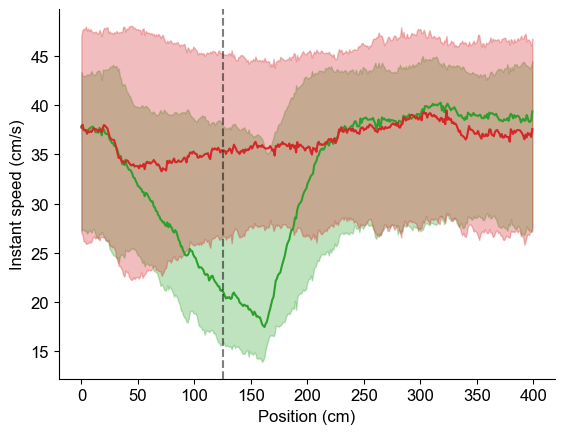

In [50]:
for it, _ in enumerate([A_trials, B_trials]):
    plt.plot(np.arange(400), avg_speed_per_mouse[:,it].mean(0), color=trial_type_palette[it], label=ttype)
    plt.fill_between(np.arange(400), avg_speed_per_mouse[:,it].mean(0)-avg_speed_per_mouse[:,it].std(0), 
                     avg_speed_per_mouse[:,it].mean(0).mean(0)+avg_speed_per_mouse[:,it].std(0), alpha=0.3, color=trial_type_palette[it])
plt.axvline(125, color='k', linestyle='--', alpha=0.5)
plt.ylabel("Instant speed (cm/s)")
plt.xlabel("Position (cm)")

Ttest_relResult(statistic=-1.1142071252559347, pvalue=0.3464192915737611)


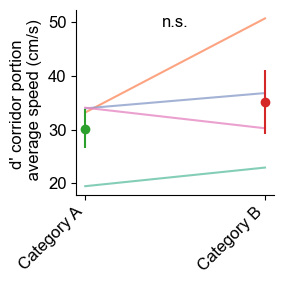

In [153]:
overall_speed_A = avg_speed_per_mouse[:,0,:125].mean(-1)
overall_speed_B = avg_speed_per_mouse[:,1,:125].mean(-1)
overall_speed_A_sem = sem(overall_speed_A, axis=0)
overall_speed_B_sem = sem(overall_speed_B, axis=0)

fig, ax = plt.subplots(1,1, figsize=(3, 3), sharey=True)
#for animal in range(4):
#    ax.scatter(0,overall_speed_A[animal], color='tab:green', alpha=0.5, s=10)
#    ax.scatter(1,overall_speed_B[animal],  color='tab:red', alpha=0.5, s=10)
ax.errorbar(-.1, overall_speed_A.mean(0), yerr=overall_speed_A_sem, color='tab:green')
ax.scatter(-.1, overall_speed_A.mean(0), color='tab:green')
ax.errorbar(.1, overall_speed_B.mean(0), yerr=overall_speed_B_sem, color='tab:red')
ax.scatter(.1, overall_speed_B.mean(0), color='tab:red')
ax.set_ylabel("d' corridor portion \n average speed (cm/s)")
ax.set_xticks([-.1,.1], ["Category A", "Category B"], rotation=45, ha='right');
# connect dots 
mouse_colors = sns.color_palette("Set2", 4)
for animal in range(4):
    ax.plot([-.1,.1], [overall_speed_A[animal], overall_speed_B[animal]], color=mouse_colors[animal], alpha=0.8, zorder=0)
ax.text(0, 50, "n.s.", ha='center', va='center')
plt.tight_layout()
# compute the paired ttest between the two conditions
from scipy.stats import ttest_rel
print(ttest_rel(overall_speed_A, overall_speed_B))

Text(0.5, 0, 'Position (cm)')

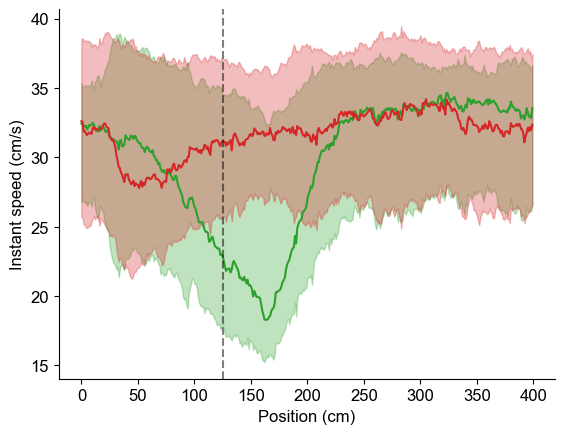

In [52]:
mice = [0,2,3]
for it, _ in enumerate([A_trials, B_trials]):
    plt.plot(np.arange(400), avg_speed_per_mouse[mice,it].mean(0), color=trial_type_palette[it], label=ttype)
    plt.fill_between(np.arange(400), avg_speed_per_mouse[mice,it].mean(0)-avg_speed_per_mouse[mice,it].std(0), 
                     avg_speed_per_mouse[mice,it].mean(0).mean(0)+avg_speed_per_mouse[mice,it].std(0), alpha=0.3, color=trial_type_palette[it])
plt.axvline(125, color='k', linestyle='--', alpha=0.5)
plt.ylabel("Instant speed (cm/s)")
plt.xlabel("Position (cm)")

Text(0.5, 0, 'Position (cm)')

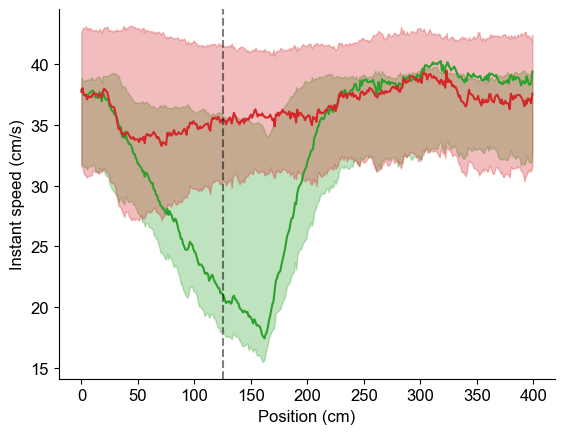

In [51]:
for it, _ in enumerate([A_trials, B_trials]):
    plt.plot(np.arange(400), avg_speed_per_mouse[:,it].mean(0), color=trial_type_palette[it], label=ttype)
    plt.fill_between(np.arange(400), avg_speed_per_mouse[:,it].mean(0)-sem(avg_speed_per_mouse[:,it], axis=0), 
                     avg_speed_per_mouse[:,it].mean(0).mean(0)+sem(avg_speed_per_mouse[:,it], axis=0), alpha=0.3, color=trial_type_palette[it])
plt.axvline(125, color='k', linestyle='--', alpha=0.5)
plt.ylabel("Instant speed (cm/s)")
plt.xlabel("Position (cm)")

Text(0.5, 0, 'Position (cm)')

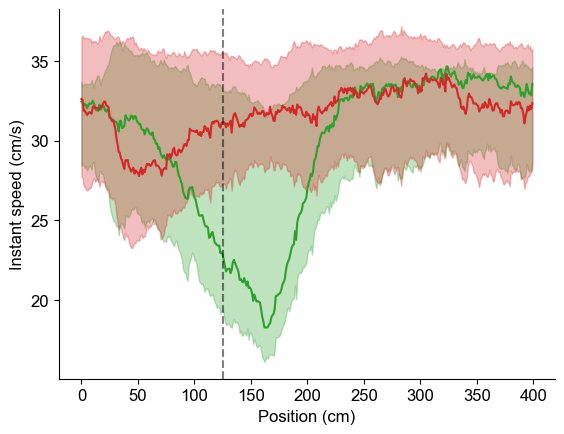

In [53]:
for it, _ in enumerate([A_trials, B_trials]):
    plt.plot(np.arange(400), avg_speed_per_mouse[mice,it].mean(0), color=trial_type_palette[it], label=ttype)
    plt.fill_between(np.arange(400), avg_speed_per_mouse[mice,it].mean(0)-sem(avg_speed_per_mouse[mice,it], axis=0), 
                     avg_speed_per_mouse[mice,it].mean(0).mean(0)+sem(avg_speed_per_mouse[mice,it], axis=0), alpha=0.3, color=trial_type_palette[it])
plt.axvline(125, color='k', linestyle='--', alpha=0.5)
plt.ylabel("Instant speed (cm/s)")
plt.xlabel("Position (cm)")

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_21\2
Existing mouse object has the following attr

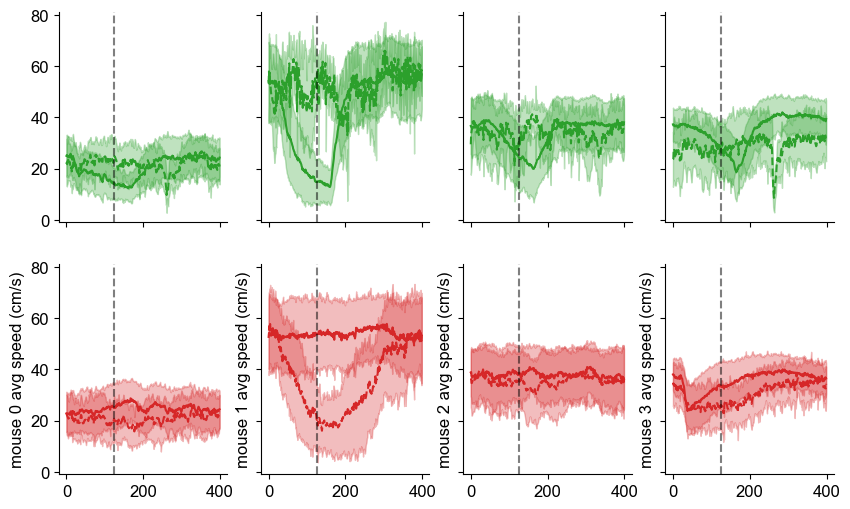

In [44]:
from scipy.stats import pearsonr
areas = ["V1", "medial", "lateral", "anterior"]
fig, ax = plt.subplots(2,4, figsize=(10, 6), sharey=True, sharex=True)
for iss, sess in enumerate(all_sessions):
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    ax[1,iss].set_ylabel(f"mouse {iss} avg speed (cm/s)")
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
    speed = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/speed_interp.npy")
    t_licks_r, t_no_licks_r = utils.get_trials_with_licks(m1, lick_window=(150,250), trialtype='rewarded')
    t_licks_rt, t_no_licks_rt = utils.get_trials_with_licks(m1, lick_window=(150,250), trialtype='rewarded test')
    t_licks_nr, t_no_licks_nr = utils.get_trials_with_licks(m1, lick_window=(150,250), trialtype='non rewarded')
    t_licks_nrt, t_no_licks_nrt = utils.get_trials_with_licks(m1, lick_window=(150,250), trialtype='non rewarded test')
    A_wlick = np.concatenate([t_licks_r, t_licks_rt])
    B_wlick = np.concatenate([t_licks_nr, t_licks_nrt])
    A_nlick = np.concatenate([t_no_licks_r, t_no_licks_rt])
    B_nlick = np.concatenate([t_no_licks_nr, t_no_licks_nrt])
    ax[0,iss].plot(np.arange(400), speed[A_wlick].mean(0), color=trial_type_palette[0])
    ax[0,iss].fill_between(np.arange(400), speed[A_wlick].mean(0)-speed[A_wlick].std(0), speed[A_wlick].mean(0)+speed[A_wlick].std(0), alpha=0.3, color=trial_type_palette[0])
    ax[0,iss].plot(np.arange(400), speed[A_nlick].mean(0), color=trial_type_palette[0], linestyle='--')
    ax[0,iss].fill_between(np.arange(400), speed[A_nlick].mean(0)-speed[A_nlick].std(0), speed[A_nlick].mean(0)+speed[A_nlick].std(0), alpha=0.3, color=trial_type_palette[0])
    ax[1,iss].plot(np.arange(400), speed[B_wlick].mean(0), color=trial_type_palette[1], linestyle = '--')
    ax[1,iss].fill_between(np.arange(400), speed[B_wlick].mean(0)-speed[B_wlick].std(0), speed[B_wlick].mean(0)+speed[B_wlick].std(0), alpha=0.3, color=trial_type_palette[1])
    ax[1,iss].plot(np.arange(400), speed[B_nlick].mean(0), color=trial_type_palette[1])
    ax[1,iss].fill_between(np.arange(400), speed[B_nlick].mean(0)-speed[B_nlick].std(0), speed[B_nlick].mean(0)+speed[B_nlick].std(0), alpha=0.3, color=trial_type_palette[1])
    ax[0,iss].axvline(125, color='k', linestyle='--', alpha=0.5)
    ax[1,iss].axvline(125, color='k', linestyle='--', alpha=0.5)

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_21\2
Existing mouse object has the following attr

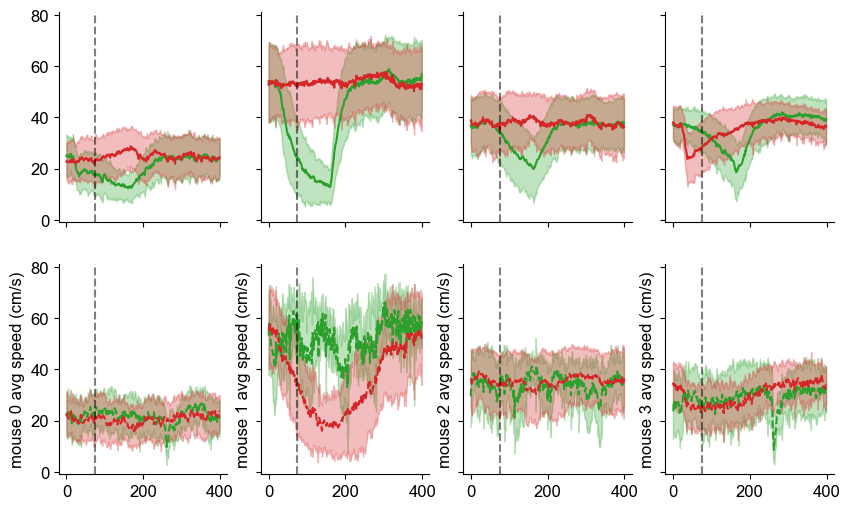

In [46]:
areas = ["V1", "medial", "lateral", "anterior"]
fig, ax = plt.subplots(2,4, figsize=(10, 6), sharey=True, sharex=True)
for iss, sess in enumerate(all_sessions):
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    ax[1,iss].set_ylabel(f"mouse {iss} avg speed (cm/s)")
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
    speed = np.load(f"../data/{m1.name}/{m1.datexp}/{m1.blk}/speed_interp.npy")
    t_licks_r, t_no_licks_r = utils.get_trials_with_licks(m1, lick_window=(150,250), trialtype='rewarded')
    t_licks_rt, t_no_licks_rt = utils.get_trials_with_licks(m1, lick_window=(150,250), trialtype='rewarded test')
    t_licks_nr, t_no_licks_nr = utils.get_trials_with_licks(m1, lick_window=(150,250), trialtype='non rewarded')
    t_licks_nrt, t_no_licks_nrt = utils.get_trials_with_licks(m1, lick_window=(150,250), trialtype='non rewarded test')
    A_wlick = np.concatenate([t_licks_r, t_licks_rt])
    B_wlick = np.concatenate([t_licks_nr, t_licks_nrt])
    A_nlick = np.concatenate([t_no_licks_r, t_no_licks_rt])
    B_nlick = np.concatenate([t_no_licks_nr, t_no_licks_nrt])
    ax[0,iss].plot(np.arange(400), speed[A_wlick].mean(0), color=trial_type_palette[0])
    ax[0,iss].fill_between(np.arange(400), speed[A_wlick].mean(0)-speed[A_wlick].std(0), speed[A_wlick].mean(0)+speed[A_wlick].std(0), alpha=0.3, color=trial_type_palette[0])
    ax[1,iss].plot(np.arange(400), speed[A_nlick].mean(0), color=trial_type_palette[0], linestyle='--')
    ax[1,iss].fill_between(np.arange(400), speed[A_nlick].mean(0)-speed[A_nlick].std(0), speed[A_nlick].mean(0)+speed[A_nlick].std(0), alpha=0.3, color=trial_type_palette[0])
    ax[1,iss].plot(np.arange(400), speed[B_wlick].mean(0), color=trial_type_palette[1], linestyle = '--')
    ax[1,iss].fill_between(np.arange(400), speed[B_wlick].mean(0)-speed[B_wlick].std(0), speed[B_wlick].mean(0)+speed[B_wlick].std(0), alpha=0.3, color=trial_type_palette[1])
    ax[0,iss].plot(np.arange(400), speed[B_nlick].mean(0), color=trial_type_palette[1])
    ax[0,iss].fill_between(np.arange(400), speed[B_nlick].mean(0)-speed[B_nlick].std(0), speed[B_nlick].mean(0)+speed[B_nlick].std(0), alpha=0.3, color=trial_type_palette[1])
    ax[0,iss].axvline(75, color='k', linestyle='--', alpha=0.5)
    ax[1,iss].axvline(75, color='k', linestyle='--', alpha=0.5)